# Análisis de Autores Activos: Mapping Review IA y ML en Educación Matemática K-12

**MQ2: ¿Quiénes son los autores más activos en este campo?**

Este notebook analiza los autores más productivos y sus patrones de colaboración en el campo de IA y ML en educación matemática K-12.

## 1. Configuración del Entorno

In [1]:
# Instalación de dependencias
!pip install pandas numpy matplotlib seaborn plotly networkx

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 2. Carga de Datos desde GitHub

In [5]:
# Cargar el dataset desde GitHub

url = "https://raw.githubusercontent.com/mlproyecto/doctorado/main/MappingReview.csv"
df = pd.read_csv(url, sep=';', encoding='latin-1')

print(f"Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas")
print("\nPrimeras 5 filas:")
df.head()

Dataset cargado: 89 filas y 8 columnas

Primeras 5 filas:


,Title,Author(s),Year,Publication Title,Type of Publication,Source,DOI,Abstract
0,What Would the Matrix Do?: A Systematic Review of K-12 AI Learning Contexts and Learner-Interface Interactions,"Moore, Robert L.; Jiang, Shiyan; Abramowitz, Brian",2023,Journal of Research on Technology in Education,Article,Eric,https://doi.org/10.1080/15391523.2022.2148785,"This systematic review examines the empirical literature published between 2014 and 2021 that situates artificial intelligence within K-12 educational contexts. Our review synthesizes 12 articles and highlights artificial intelligence's instructional contexts and applications in K-12 learning environments. We focused our synThesis on the learning contexts and the learner-interface interactions. Our findings highlight that most of intelligent systems are being deployed in math or informal settings. Also, there are opportunities for more collaboration to facilitate teaching and learning in domain-specific areas. Additionally, researchers can explore how to implement more collaborative learning opportunities between intelligent tutors and learners. We conclude with a discussion of the reciprocal nature of this technology integration."
1,ML4STEM Professional Development Program: Enriching K-12 STEM Teaching with Machine Learning,"Tang, Jingwan; Zhou, Xiaofei; Wan, Xiaoyu; Daley, Michael; Bai, Zhen",2023,International Journal of Artificial Intelligence in Education,Article,Eric,https://www.doi.org/10.1007/s40593-022-00292-4,"The advances of machine learning (ML) in scientific discovery (SD) reveal exciting opportunities to utilize it as a cross-cutting tool for inquiry-based learning in K-12 STEM classrooms. There are, however, limited efforts on providing teachers with sufficient knowledge and skills to integrate ML into teaching. Our study addresses this gap by proposing a professional development (PD) program named ML4STEM. Based on existing research on supporting teacher learning in innovative technology integration, ML4STEM is composed of Teachers-as-Learners and Teachers-as-Designers sessions. It integrates an accessible ML learning platform designed for students with limited math and computing skills. We implemented this PD program and evaluated its effectiveness with 18 K-12 STEM teachers. Findings confirm that ML4STEM successfully develops teachers' understanding of teaching STEM with ML as well as fosters positive attitudes toward applying the ML as an in-class teaching technology. Discussions on the implications of our findings from ML4STEM are provided for future PD researchers and designers."
2,Integrating Machine Learning in Mathematics Classrooms,"Jones, Joshua",2021,Mathematics Teacher: Learning and Teaching PK-12,Article,Eric,https://doi.org/10.5951/MTLT.2021.0001,"Aside from being culturally relevant, artificial intelligence is also supporting companies in making business decisions. Consequently, ""workforce needs have shifted rapidly,"" resulting in a demand for applicants who are skilled in ""data, analytics, machine learning, and artificial intelligence"" (Miller and Hughes 2017). This article contributes to filling that need by exploring a lesson in which students learned how conditional probability is the crux of many machine learning algorithms, including predictive text applications. Prior to this lesson, students learned how to calculate conditional probability. Most students had also demonstrated that they were able to calculate experimental probabilities on the basis of a Venn diagram, on a word problem, and on a two-way table. The activity described in this article satisfies Common Core State Standard CCSS.MATH.CONTENT.HSS. CP.A.5."
3,"Personalized Online Learning, Test Fairness, and Educational Measurement: Considering Differential Content Exposure Prior to a High Stakes End of Course Exam","Katz, Daniel; Huggins-Manley, Anne Corinne; Leite, Walter",2022,Applied Measurement in Education,Article,Eric,https://doi.org/10.1080/08957347.2022.2034824,"Accor

## 3. Análisis de Autores Activos (MQ2)

In [6]:
# Función para extraer autores individuales
def extract_authors(authors_str):
    if pd.isna(authors_str):
        return []
    
    # Limpiar el string de autores
    authors_str = str(authors_str).strip()
    
    # Dividir por punto y coma y limpiar
    authors = [author.strip() for author in authors_str.split(';')]
    
    # Remover entradas vacías
    authors = [author for author in authors if author]
    
    return authors

# Aplicar extracción de autores
df['Authors_List'] = df['Author(s)'].apply(extract_authors)

print("Extracción de autores completada")
print(f"Publicaciones con autores extraídos: {len(df[df['Authors_List'].apply(len) > 0])}")

Extracción de autores completada
Publicaciones con autores extraídos: 89


In [7]:
# Contar frecuencia de autores
all_authors = []
for authors_list in df['Authors_List']:
    all_authors.extend(authors_list)

author_counts = Counter(all_authors)

print("=== AUTORES MÁS FRECUENTES ===")
for author, count in author_counts.most_common(15):
    print(f"{author}: {count} publicaciones")

print(f"\nTotal de autores únicos: {len(author_counts)}")
print(f"Total de apariciones de autores: {sum(author_counts.values())}")

=== AUTORES MÁS FRECUENTES ===
Xing W.: 4 publicaciones
Li C.: 4 publicaciones
Drachsler, Hendrik: 2 publicaciones
R. Majumdar: 2 publicaciones
H. Ogata: 2 publicaciones
Borchers C.: 2 publicaciones
Aleven V.: 2 publicaciones
Lyu B.: 2 publicaciones
Li H.: 2 publicaciones
Song Y.: 2 publicaciones
Parra V.: 2 publicaciones
Sureda P.: 2 publicaciones
Schiaffino S.: 2 publicaciones
Godoy D.: 2 publicaciones
Marghitu D.: 2 publicaciones

Total de autores únicos: 335
Total de apariciones de autores: 359


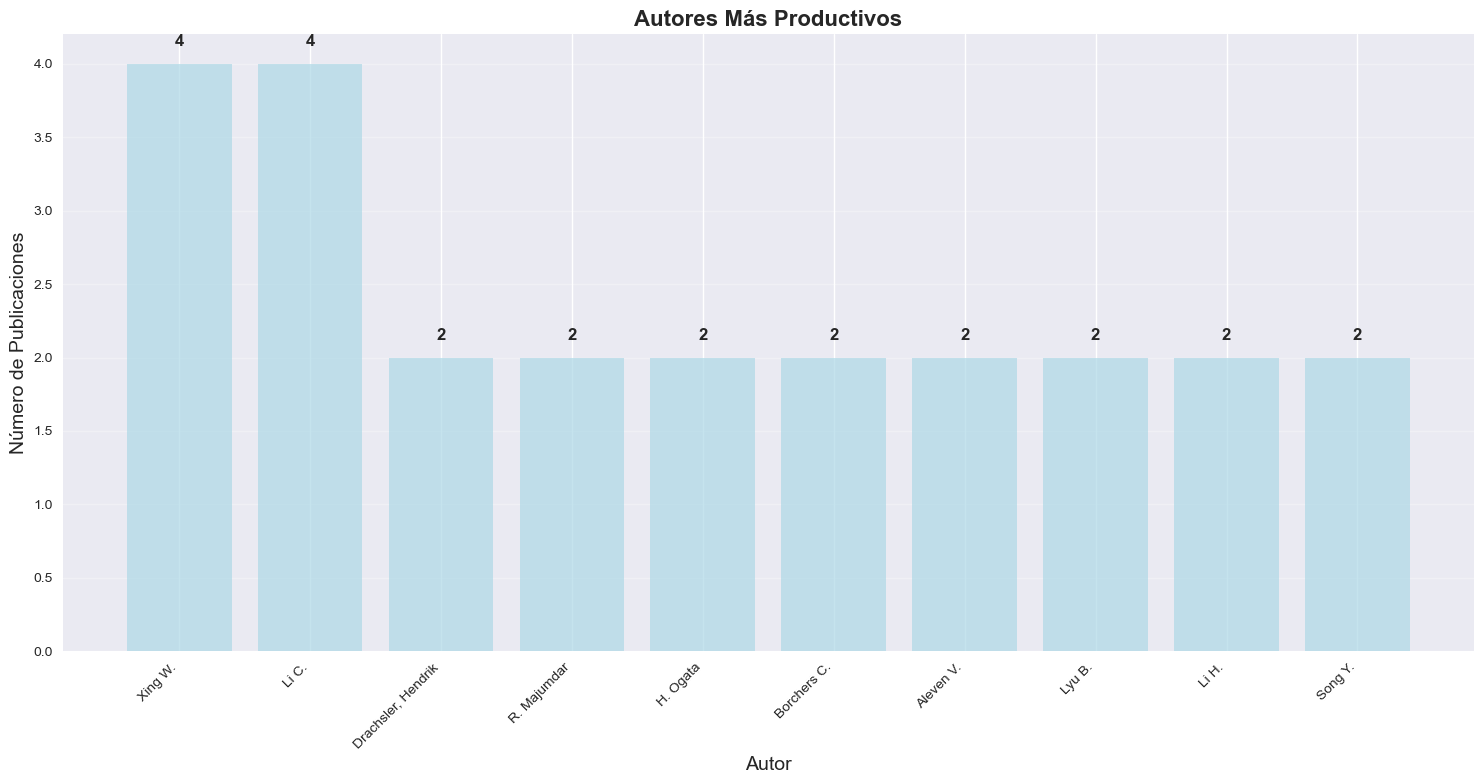

In [8]:
# Gráfico de barras para autores más frecuentes
top_authors = dict(author_counts.most_common(10))

plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(top_authors)), top_authors.values(), color='lightblue', alpha=0.7)
plt.xlabel('Autor', fontsize=14)
plt.ylabel('Número de Publicaciones', fontsize=14)
plt.title('Autores Más Productivos', fontsize=16, fontweight='bold')
plt.xticks(range(len(top_authors)), list(top_authors.keys()), rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, count) in enumerate(zip(bars, top_authors.values())):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Gráfico interactivo con Plotly
fig = px.bar(x=list(top_authors.keys()), y=list(top_authors.values()),
              title='Autores Más Productivos',
              labels={'x': 'Autor', 'y': 'Número de Publicaciones'})

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14
)

fig.show()

## 4. Análisis de Colaboraciones

In [10]:
# Crear red de colaboraciones
G = nx.Graph()

# Agregar nodos (autores)
for author in author_counts.keys():
    G.add_node(author, weight=author_counts[author])

# Agregar edges (colaboraciones)
for authors_list in df['Authors_List']:
    if len(authors_list) > 1:
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                author1 = authors_list[i]
                author2 = authors_list[j]
                
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

print(f"Red de colaboraciones creada")
print(f"Número de nodos (autores): {G.number_of_nodes()}")
print(f"Número de edges (colaboraciones): {G.number_of_edges()}")

Red de colaboraciones creada
Número de nodos (autores): 335
Número de edges (colaboraciones): 722


In [11]:
# Análisis de centralidad
centrality_degree = nx.degree_centrality(G)
centrality_betweenness = nx.betweenness_centrality(G)
centrality_closeness = nx.closeness_centrality(G)

# Top autores por centralidad
top_degree = sorted(centrality_degree.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(centrality_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
top_closeness = sorted(centrality_closeness.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== TOP 10 AUTORES POR CENTRALIDAD ===")
print("\nPor Grado:")
for author, centrality in top_degree:
    print(f"{author}: {centrality:.3f}")

print("\nPor Intermediación:")
for author, centrality in top_betweenness:
    print(f"{author}: {centrality:.3f}")

print("\nPor Cercanía:")
for author, centrality in top_closeness:
    print(f"{author}: {centrality:.3f}")

=== TOP 10 AUTORES POR CENTRALIDAD ===

Por Grado:
Drachsler, Hendrik: 0.039
Kubsch, Marcus: 0.033
Czinczel, Berrit: 0.033
Lossjew, Jannik: 0.033
Wyrwich, Tobias: 0.033
Bednorz, David: 0.033
Bernholt, Sascha: 0.033
Fiedler, Daniela: 0.033
Strauss, Sebastian: 0.033
Cress, Ulrike: 0.033

Por Intermediación:
Li H.: 0.001
Ogata H.: 0.001
Drachsler, Hendrik: 0.000
Xing W.: 0.000
Li C.: 0.000
Kang Y.: 0.000
Wang G.: 0.000
Borchers C.: 0.000
Aleven V.: 0.000
Wang W.: 0.000

Por Cercanía:
Drachsler, Hendrik: 0.039
Kubsch, Marcus: 0.034
Czinczel, Berrit: 0.034
Lossjew, Jannik: 0.034
Wyrwich, Tobias: 0.034
Bednorz, David: 0.034
Bernholt, Sascha: 0.034
Fiedler, Daniela: 0.034
Strauss, Sebastian: 0.034
Cress, Ulrike: 0.034


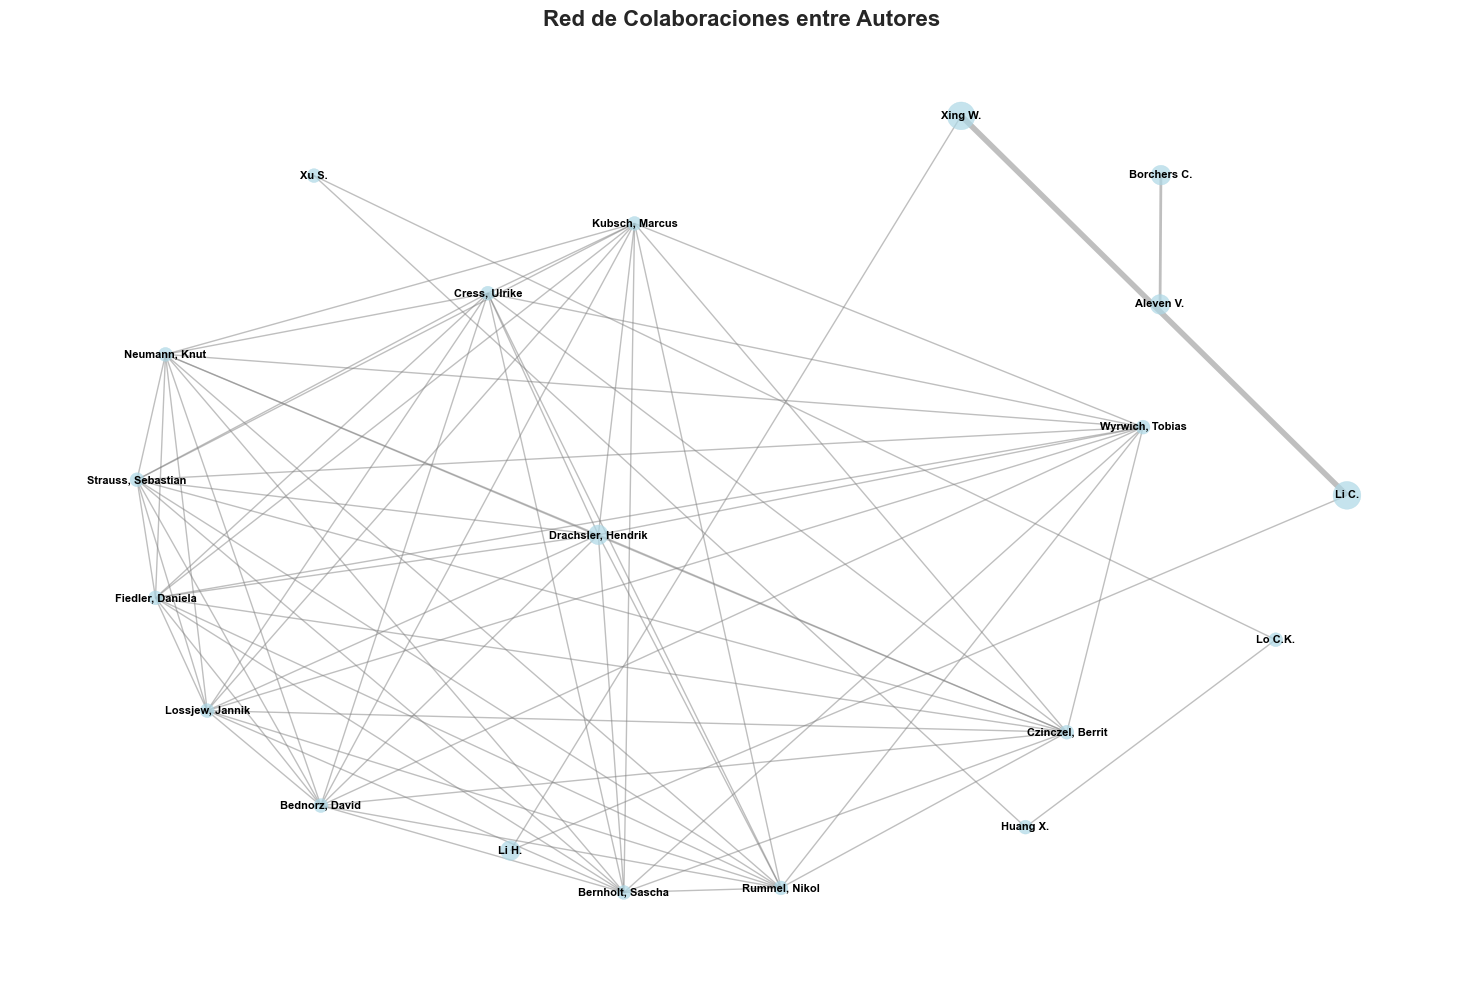

In [12]:
# Gráfico de la red de colaboraciones (versión simplificada)
# Usar solo los autores más conectados para visualización
top_connected = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:20]
subgraph = G.subgraph([author for author, degree in top_connected])

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph, k=3, iterations=50)

# Dibujar nodos
node_sizes = [author_counts[author] * 100 for author in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)

# Dibujar edges
edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
nx.draw_networkx_edges(subgraph, pos, width=edge_weights, alpha=0.5, edge_color='gray')

# Dibujar etiquetas
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight='bold')

plt.title('Red de Colaboraciones entre Autores', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Análisis de Tamaños de Equipo

In [13]:
# Análisis de tamaños de equipo
team_sizes = df['Authors_List'].apply(len)
team_size_counts = team_sizes.value_counts().sort_index()

print("=== DISTRIBUCIÓN DE TAMAÑOS DE EQUIPO ===")
for size, count in team_size_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{size} autor(es): {count} publicaciones ({percentage:.1f}%)")

print(f"\nPromedio de autores por publicación: {team_sizes.mean():.2f}")
print(f"Mediana de autores por publicación: {team_sizes.median():.0f}")
print(f"Máximo de autores por publicación: {team_sizes.max()}")
print(f"Mínimo de autores por publicación: {team_sizes.min()}")

=== DISTRIBUCIÓN DE TAMAÑOS DE EQUIPO ===
1 autor(es): 6 publicaciones (6.7%)
2 autor(es): 14 publicaciones (15.7%)
3 autor(es): 23 publicaciones (25.8%)
4 autor(es): 14 publicaciones (15.7%)
5 autor(es): 14 publicaciones (15.7%)
6 autor(es): 10 publicaciones (11.2%)
7 autor(es): 1 publicaciones (1.1%)
8 autor(es): 4 publicaciones (4.5%)
9 autor(es): 1 publicaciones (1.1%)
10 autor(es): 1 publicaciones (1.1%)
12 autor(es): 1 publicaciones (1.1%)

Promedio de autores por publicación: 4.03
Mediana de autores por publicación: 4
Máximo de autores por publicación: 12
Mínimo de autores por publicación: 1


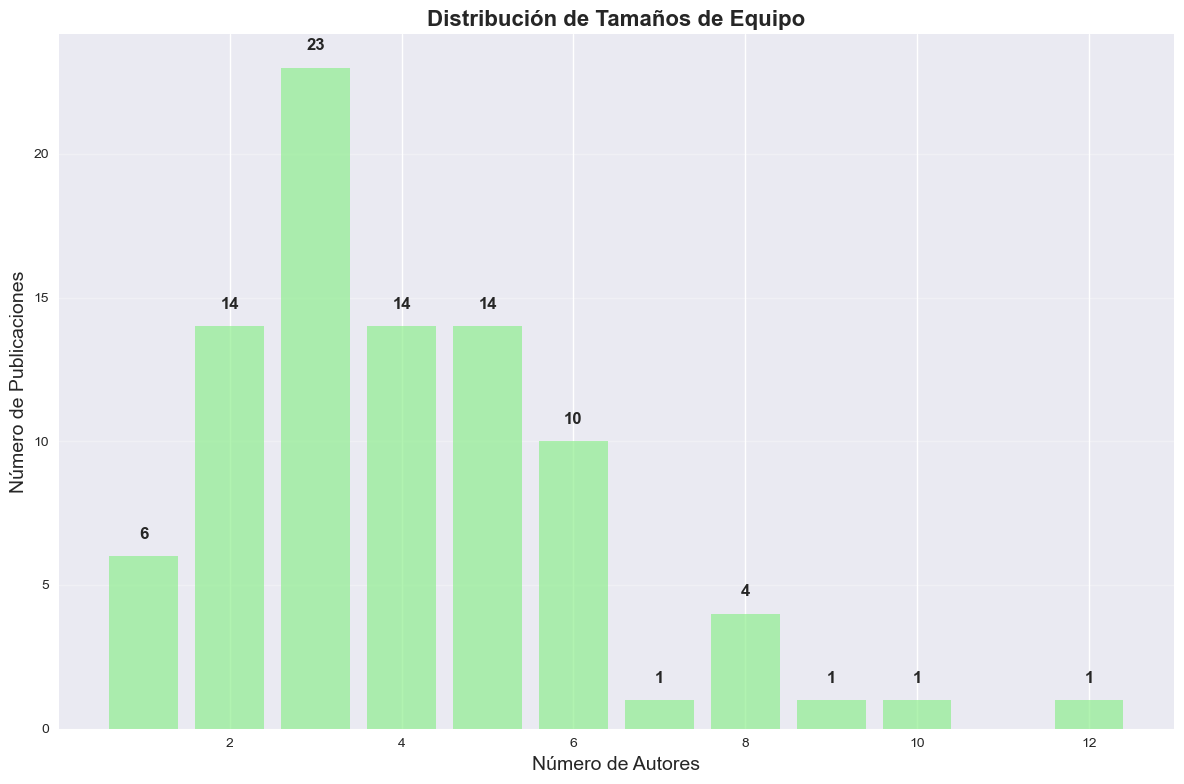

In [14]:
# Gráfico de distribución de tamaños de equipo
plt.figure(figsize=(12, 8))
bars = plt.bar(team_size_counts.index, team_size_counts.values, color='lightgreen', alpha=0.7)
plt.xlabel('Número de Autores', fontsize=14)
plt.ylabel('Número de Publicaciones', fontsize=14)
plt.title('Distribución de Tamaños de Equipo', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, count) in enumerate(zip(bars, team_size_counts.values)):
    plt.text(team_size_counts.index[i], count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Resumen y Conclusiones

In [15]:
# Generar resumen ejecutivo
print("=== RESUMEN EJECUTIVO ===\n")

print(f"📊 Total de autores únicos: {len(author_counts)}")
print(f"📝 Autor más productivo: {author_counts.most_common(1)[0][0]} ({author_counts.most_common(1)[0][1]} publicaciones)")
print(f"👥 Promedio de autores por publicación: {team_sizes.mean():.2f}")
print(f"🔗 Colaboraciones únicas: {G.number_of_edges()}")

# Análisis de colaboración
solo_authors = len(df[df['Authors_List'].apply(len) == 1])
collaborative = len(df[df['Authors_List'].apply(len) > 1])
collaboration_percentage = (collaborative / len(df)) * 100

print(f"📈 Publicaciones colaborativas: {collaborative} ({collaboration_percentage:.1f}%)")
print(f"📉 Publicaciones individuales: {solo_authors} ({100 - collaboration_percentage:.1f}%)")

# Autor más central
most_central = top_degree[0]
print(f"🏆 Autor más central: {most_central[0]} (centralidad: {most_central[1]:.3f})")

print("\n=== CONCLUSIONES ===")
print("1. Hay autores claramente más productivos en el campo")
print("2. Existe una red de colaboraciones significativa")
print("3. La mayoría de publicaciones son colaborativas")
print("4. Hay autores que actúan como conectores en la red")

=== RESUMEN EJECUTIVO ===

📊 Total de autores únicos: 335
📝 Autor más productivo: Xing W. (4 publicaciones)
👥 Promedio de autores por publicación: 4.03
🔗 Colaboraciones únicas: 722
📈 Publicaciones colaborativas: 83 (93.3%)
📉 Publicaciones individuales: 6 (6.7%)
🏆 Autor más central: Drachsler, Hendrik (centralidad: 0.039)

=== CONCLUSIONES ===
1. Hay autores claramente más productivos en el campo
2. Existe una red de colaboraciones significativa
3. La mayoría de publicaciones son colaborativas
4. Hay autores que actúan como conectores en la red
